In [37]:
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler, StableDiffusionImg2ImgPipeline
from lora_diffusion.lora import tune_lora_scale, patch_pipe
import torch
from PIL import Image
import numpy as np
from IPython.display import display
import cv2
import numpy as np
import PIL

print("库导入完成")

库导入完成


In [ ]:
# ==== Cell 2: 加载模型和LoRA ====
model_id = "/root/stable-diffusion-2-1-base"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to("cuda:0")
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

# 加载你的LoRA权重
patch_pipe(
    pipe,
    "/root/lora/lora_weight/bottle_broken_large/final_lora.safetensors",
    patch_text=True,
    patch_ti=True,
    patch_unet=True,
)

tune_lora_scale(pipe.unet, 1.0)
tune_lora_scale(pipe.text_encoder, 1.0)

prompt = "a photo of a great <bottle_broken_large>"
print("模型加载完成")

NameError: name 'StableDiffusionPipeline' is not defined

In [39]:
def method1_img2img(prompt_test, reference_image, strength=0.7, SEED=1234, width=512, height=512):
    """使用img2img pipeline，支持自定义输出尺寸"""
    img2img_pipe = StableDiffusionImg2ImgPipeline(
        vae=pipe.vae,
        text_encoder=pipe.text_encoder,
        tokenizer=pipe.tokenizer,
        unet=pipe.unet,
        scheduler=pipe.scheduler,
        safety_checker=pipe.safety_checker,
        feature_extractor=pipe.feature_extractor,
    )
    
    # 检查输入类型并相应处理
    if isinstance(reference_image, str):
        # 如果是字符串路径，则加载图像
        reference_image = Image.open(reference_image).convert("RGB")
    elif isinstance(reference_image, Image.Image):
        # 如果已经是PIL Image，确保是RGB格式
        reference_image = reference_image.convert("RGB")
    else:
        raise ValueError("reference_image must be either a file path or PIL Image")
    
    # 调整图像尺寸到指定的width和height
    reference_image = reference_image.resize((width, height))
    
    torch.manual_seed(SEED)
    image = img2img_pipe(
        prompt=prompt_test,
        image=reference_image,
        strength=strength,
        width=width,      # 添加width参数
        height=height,    # 添加height参数
        num_inference_steps=50,
        guidance_scale=7.5
    ).images[0]
    
    return image ,reference_image

print("方法1定义完成 - 支持自定义尺寸")

方法1定义完成 - 支持自定义尺寸


You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


开始生成图片...


100%|██████████| 35/35 [00:01<00:00, 26.71it/s]


生成完成！
(900, 900, 3)


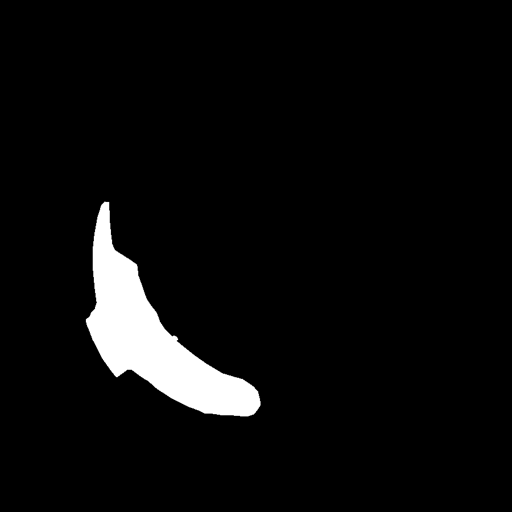

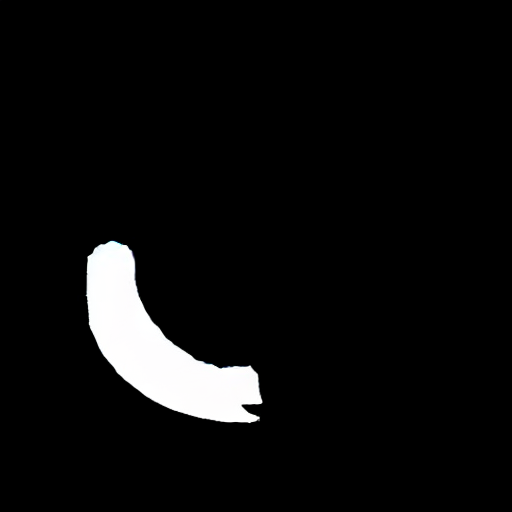

In [45]:
reference_image_path = "/root/lora/data/mvtec_anomaly_detection/bottle/ground_truth/broken_large/014_mask.png"  # 请修改这个路径！

# === 读取原图 ===
orig_img1 = cv2.imread(reference_image_path)
orig_img = Image.open(reference_image_path).convert("RGB").resize((512, 512))
orig_np = np.array(orig_img)

# === 生成 Canny 边缘图 ===
gray = cv2.cvtColor(orig_np, cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(gray, 50, 100)
edges_3ch = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB) # 转成 3 通道，和原图一致
guide = Image.fromarray(edges_3ch)

print("开始生成图片...")
result1, ref_img = method1_img2img(prompt, orig_img, strength=0.7, SEED = 42)
result1.save("../contents/result_img2img.jpg")
print("生成完成！")

# 在notebook中显示图片
print(orig_img1.shape)
display(orig_img)
display(result1)

原始训练图片:


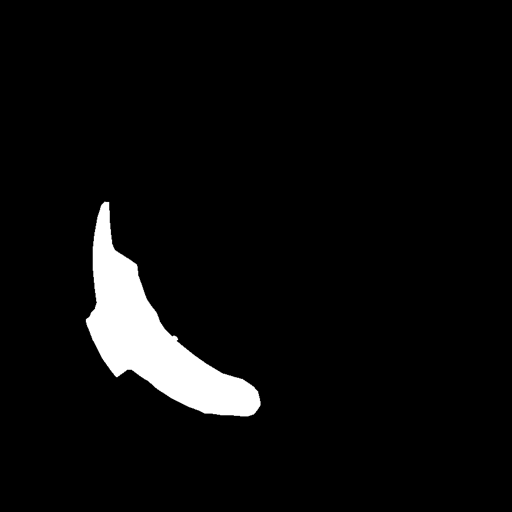


生成的图片:


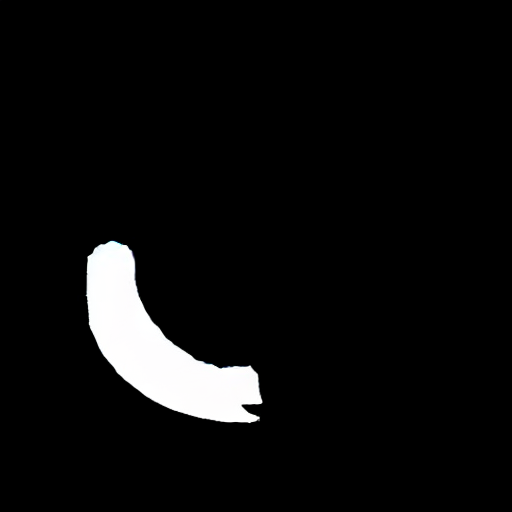

In [46]:
reference_img = Image.open(reference_image_path).resize((512, 512))

print("原始训练图片:")
display(reference_img)
print("\n生成的图片:")
display(result1)

In [47]:
def method1_binary_mask(prompt_test, reference_image, strength=0.7, SEED=1234, width=512, height=512, threshold=0.5):
    """生成二值掩码的img2img pipeline"""
    img2img_pipe = StableDiffusionImg2ImgPipeline(
        vae=pipe.vae,
        text_encoder=pipe.text_encoder,
        tokenizer=pipe.tokenizer,
        unet=pipe.unet,
        scheduler=pipe.scheduler,
        safety_checker=pipe.safety_checker,
        feature_extractor=pipe.feature_extractor,
    )
    
    # 检查输入类型并相应处理
    if isinstance(reference_image, str):
        reference_image = Image.open(reference_image).convert("RGB")
    elif isinstance(reference_image, Image.Image):
        reference_image = reference_image.convert("RGB")
    else:
        raise ValueError("reference_image must be either a file path or PIL Image")
    
    # 调整图像尺寸
    reference_image = reference_image.resize((width, height))
    
    torch.manual_seed(SEED)
    image = img2img_pipe(
        prompt=prompt_test,
        image=reference_image,
        strength=strength,
        width=width,
        height=height,
        num_inference_steps=50,
        guidance_scale=7.5
    ).images[0]
    
    # ===== 关键部分：将生成的图像转换为二值掩码 =====
    # 转换为numpy数组
    image_np = np.array(image)
    
    # 转换为灰度图
    if len(image_np.shape) == 3:
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    else:
        gray = image_np
    
    # 二值化处理 - 使用阈值
    _, binary_mask = cv2.threshold(gray, int(threshold * 255), 255, cv2.THRESH_BINARY)
    
    # 转换回PIL Image（保持为灰度图）
    binary_image = Image.fromarray(binary_mask, mode='L')
    
    # 如果需要RGB格式的二值图像
    binary_rgb = Image.fromarray(np.stack([binary_mask, binary_mask, binary_mask], axis=2))
    
    return binary_rgb, binary_image, reference_image

print("二值掩码生成函数定义完成")

二值掩码生成函数定义完成


You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


测试strength=0.3


100%|██████████| 15/15 [00:00<00:00, 25.96it/s]

Strength 0.3 - RGB二值图:


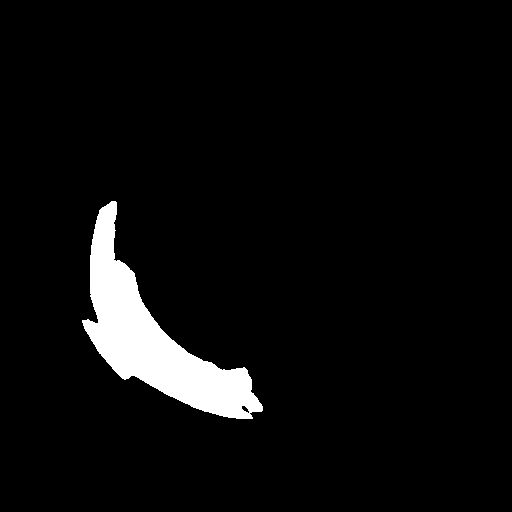

Strength 0.3 - 纯二值图:


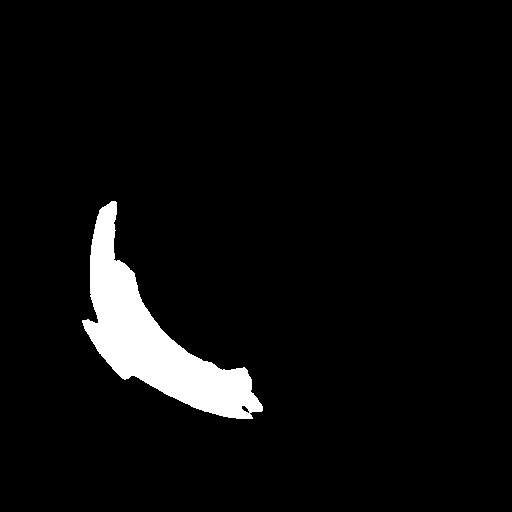

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


--------------------------------------------------
测试strength=0.5


100%|██████████| 25/25 [00:00<00:00, 26.40it/s]


Strength 0.5 - RGB二值图:


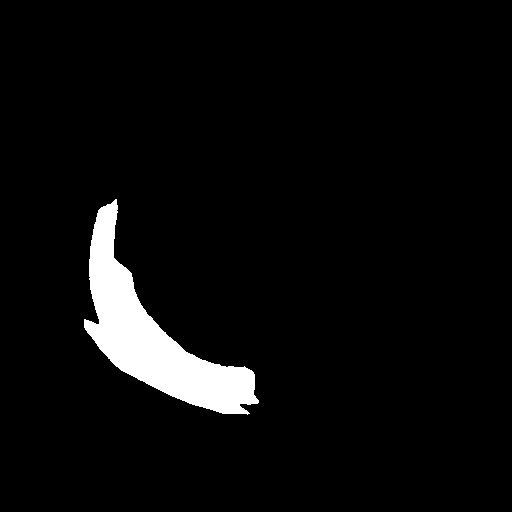

Strength 0.5 - 纯二值图:


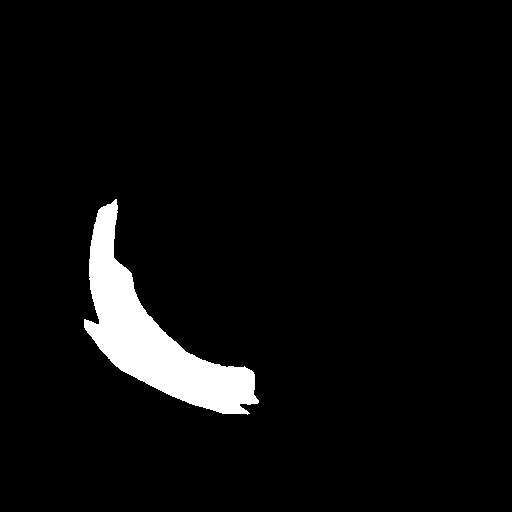

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


--------------------------------------------------
测试strength=0.7


100%|██████████| 35/35 [00:01<00:00, 26.76it/s]


Strength 0.7 - RGB二值图:


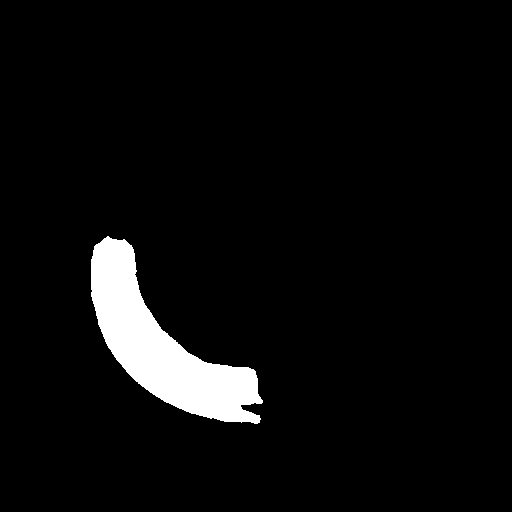

Strength 0.7 - 纯二值图:


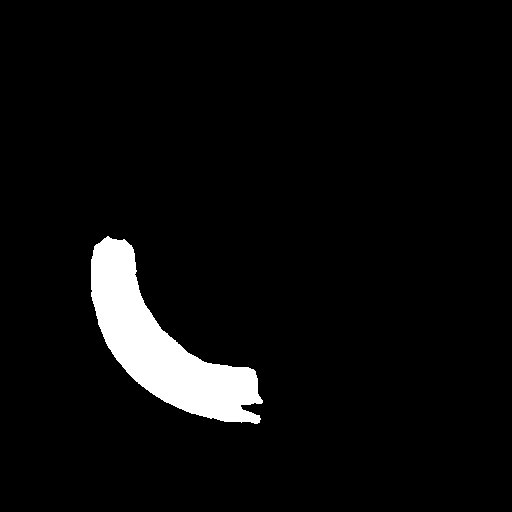

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


--------------------------------------------------
测试strength=0.9


100%|██████████| 45/45 [00:01<00:00, 26.83it/s]

Strength 0.9 - RGB二值图:


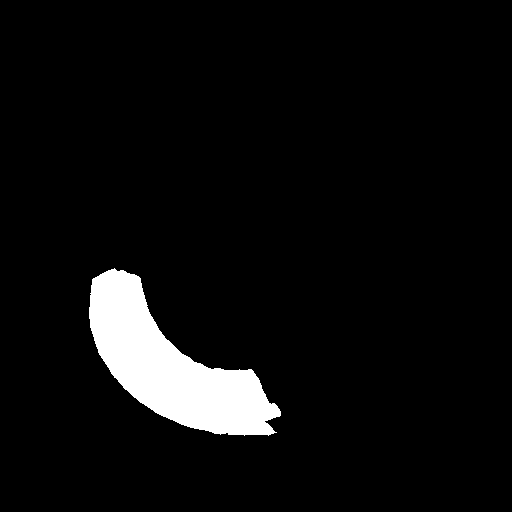

Strength 0.9 - 纯二值图:


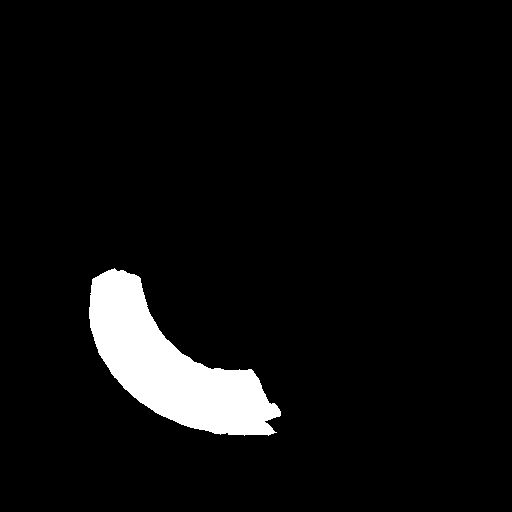

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


--------------------------------------------------
测试strength=1.0


100%|██████████| 50/50 [00:01<00:00, 26.17it/s]


Strength 1.0 - RGB二值图:


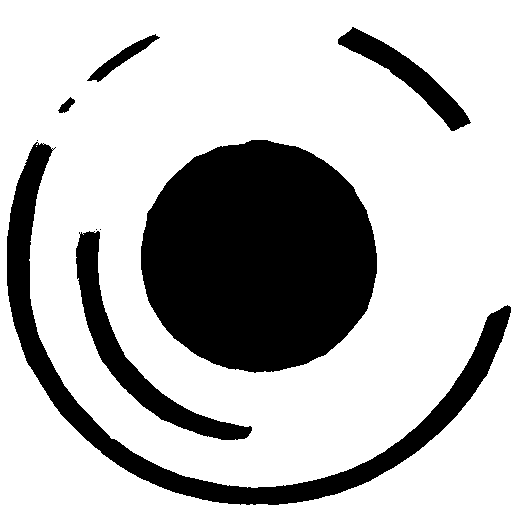

Strength 1.0 - 纯二值图:


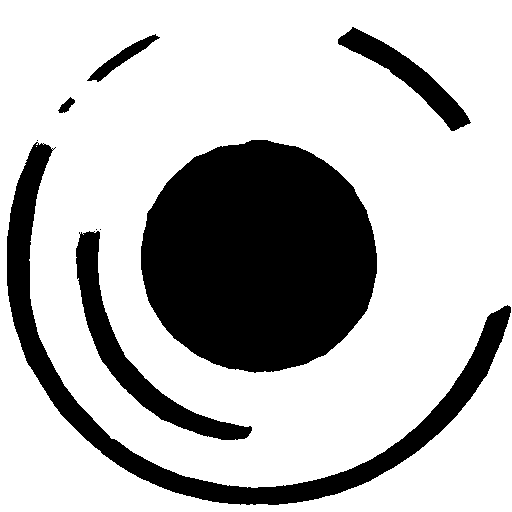

--------------------------------------------------


In [48]:
# 替换第6个cell的内容
strengths = [0.3, 0.5, 0.7, 0.9, 1.0]
results = []
binary_results = []

for strength in strengths:
    print(f"测试strength={strength}")
    
    # 使用新的二值掩码生成函数
    result_rgb, result_binary, _ = method1_binary_mask(prompt, reference_img, strength=strength, threshold=0.5)
    
    results.append(result_rgb)
    binary_results.append(result_binary)
    
    # 保存RGB版本和纯二值版本
    result_rgb.save(f"../contents/result_binary_rgb_{strength}.jpg")
    result_binary.save(f"../contents/result_binary_gray_{strength}.png")
    
    print(f"Strength {strength} - RGB二值图:")
    display(result_rgb)
    print(f"Strength {strength} - 纯二值图:")
    display(result_binary)
    print("-" * 50)

原始纯文本生成方法:


100%|██████████| 50/50 [00:01<00:00, 27.25it/s]


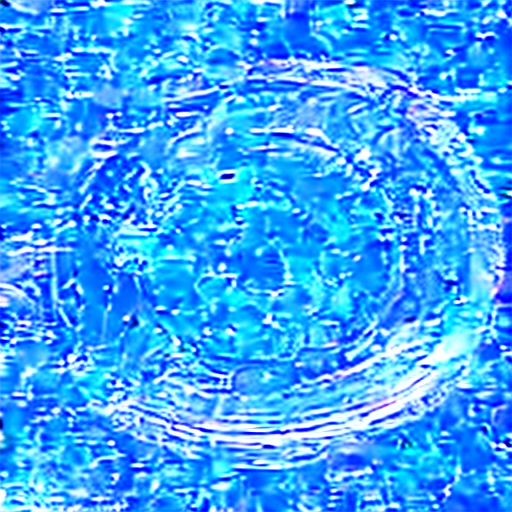


使用参考图片的方法:


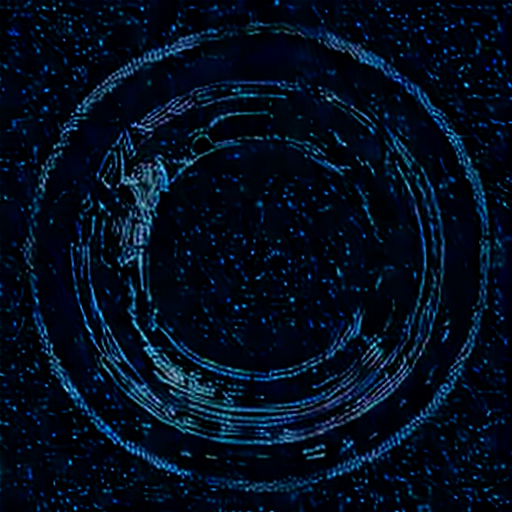

In [8]:
print("原始纯文本生成方法:")
torch.manual_seed(42)
original_result = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]
original_result.save("../contents/original_text_only.jpg")
display(original_result)

print("\n使用参考图片的方法:")
display(result1)